In [1]:
import traceback
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
# Extraction function
def get_acc_cr_records(path):
    acc_tag = "test/Acc@1_avg"
    cr_tag = "compress_ratio/total"

    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        acc = event_acc.Scalars(acc_tag)[-1].value
        cr = event_acc.Scalars(cr_tag)[-1].value
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return acc, cr




# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
path="runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-2/logs/events.out.tfevents.1675686496.NS014250.8055.0" #folderpath

In [4]:
get_acc_cr_records(path)

(19.81999969482422, 180194.0625)

In [5]:
def get_event_file_path(folder):
    for f in os.listdir(os.path.join(folder, 'logs')):
        if f.startswith("events"):
            path = os.path.join(folder, 'logs', f)
            print(path)
            return path

In [6]:
def load_results_by_dataset(dataset):
    data = defaultdict(list)

    for weight_decay in "1e-6 3e-6 1e-5 3e-5 1e-4 3e-4 1e-3 3e-3 1e-2".split():
        folder = f"runs/resnet18-spred-{dataset}/pretrain_weight_decay={weight_decay}/"
        event_file_path = get_event_file_path(folder)
        acc, cr = get_acc_cr_records(event_file_path)
        data['wd'].append(weight_decay)
        data['thr'].append(None)
        data['acc'].append(acc)
        data['cr'].append(cr)

        for threshold in "1e-6 1e-5 1e-4 1e-3 1e-2".split():
            folder = f"runs/resnet18-spred-{dataset}/pretrain_weight_decay={weight_decay}-finetune_threshold={threshold}/"
            event_file_path = get_event_file_path(folder)
            acc, cr = get_acc_cr_records(event_file_path)
            data['wd'].append(weight_decay)
            data['thr'].append(threshold)
            data['acc'].append(acc)
            data['cr'].append(cr)

    df = pd.DataFrame(data)
    return df

In [7]:
def plot_results_by_dataset(dataset, df):
    for wd, groupdf in df.groupby('wd'):
        plt.scatter(groupdf.cr, groupdf.acc, label=wd)
        plt.legend()
    plt.xscale('log')

    plt.xlabel('Compression ratio')
    plt.ylabel('Accuracy')

    # plt.xlim([1, 1e5])
    plt.ylim([0, 100])
    plt.grid()
    plt.title(dataset)

In [8]:
cifar10df = load_results_by_dataset("cifar10")

runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-6/logs/events.out.tfevents.1675558404.NS014250.2394.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-6-finetune_threshold=1e-6/logs/events.out.tfevents.1676377294.NS014250.7913.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-6-finetune_threshold=1e-5/logs/events.out.tfevents.1676393664.NS014250.6846.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-6-finetune_threshold=1e-4/logs/events.out.tfevents.1676409738.NS014250.1765.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-6-finetune_threshold=1e-3/logs/events.out.tfevents.1676425828.NS014250.28658.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=1e-6-finetune_threshold=1e-2/logs/events.out.tfevents.1676441771.NS014250.26674.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=3e-6/logs/events.out.tfevents.1675574393.NS014250.28937.0
runs/resnet18-spred-cifar10/pretrain_weight_decay=3e-6-finetune_threshold=1e-6/logs/events.out.tfevents.1676457787.NS014250.2220

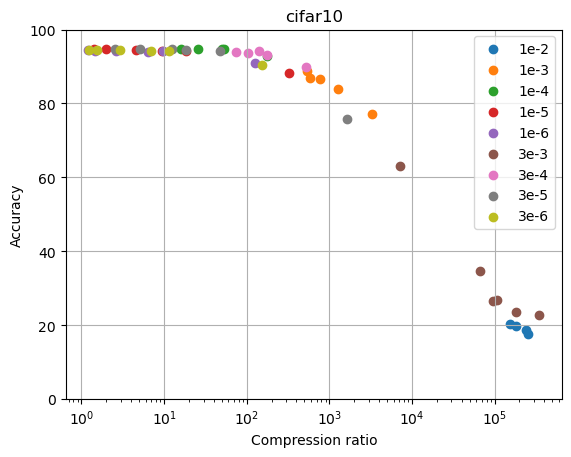

In [9]:
plot_results_by_dataset("cifar10", cifar10df)

In [10]:
cifar100df = load_results_by_dataset("cifar100")

runs/resnet18-spred-cifar100/pretrain_weight_decay=1e-6/logs/events.out.tfevents.1675558406.NS014250.2396.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=1e-6-finetune_threshold=1e-6/logs/events.out.tfevents.1676440510.NS014250.21964.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=1e-6-finetune_threshold=1e-5/logs/events.out.tfevents.1676456875.NS014250.18626.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=1e-6-finetune_threshold=1e-4/logs/events.out.tfevents.1676473294.NS014250.11156.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=1e-6-finetune_threshold=1e-3/logs/events.out.tfevents.1676489775.NS014250.3653.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=1e-6-finetune_threshold=1e-2/logs/events.out.tfevents.1676506125.NS014250.28241.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=3e-6/logs/events.out.tfevents.1675574765.NS014250.30772.0
runs/resnet18-spred-cifar100/pretrain_weight_decay=3e-6-finetune_threshold=1e-6/logs/events.out.tfevents.1676522520.NS0

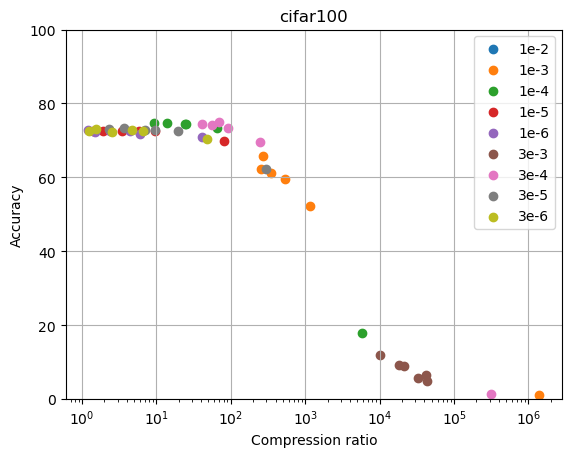

In [11]:
plot_results_by_dataset("cifar100", cifar100df)

In [13]:
cifar10df.to_csv('cifar10.csv')

In [14]:
cifar100df.to_csv('cifar100.csv')

In [18]:
cifar100df.cr.tolist()

[4.376385688781738,
 1.2183620929718018,
 1.4803122282028198,
 2.352403163909912,
 5.9532012939453125,
 40.79624938964844,
 4.689732551574707,
 1.2513076066970825,
 1.557482123374939,
 2.560054302215576,
 6.655677795410156,
 47.53175354003906,
 5.8137102127075195,
 1.401895523071289,
 1.91270911693573,
 3.458355188369751,
 9.470022201538086,
 81.30362701416016,
 9.679155349731445,
 2.319068193435669,
 3.6820015907287598,
 7.102003574371338,
 19.576183319091797,
 299.11773681640625,
 24.571325302124023,
 9.380578994750977,
 13.855917930603027,
 23.81785011291504,
 65.71097564697266,
 5870.28369140625,
 69.11023712158203,
 40.42533874511719,
 55.427371978759766,
 90.31205749511719,
 249.03680419921875,
 311614.21875,
 273.18603515625,
 257.58563232421875,
 345.5022277832031,
 535.1131591796875,
 1168.066650390625,
 1402264.0,
 10070.119140625,
 18035.548828125,
 42817.22265625,
 33091.77734375,
 21246.42578125,
 42492.8515625,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]